## Config BO

In [1]:
from langchain.prompts.prompt import PromptTemplate

initial_train = 1
initial_transfer_train=0
ask_K = 1
N=30
M=5
lambda_multi = 0.1
# model="gpt-3.5-turbo-instruct"
# model="gpt-4o"
model="gpt-3.5-turbo"
# model="gpt-4-turbo"
# model="gpr"

# Initialize Dataset

## in-house

In [ ]:
dataset="in-house"
kwargs = dict(
    prefix="",
    prompt_template=PromptTemplate(
        input_variables=["x", "y", "y_name"],
        template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
    ),
    suffix="What is the {y_name} of {x}?@@@\nA:",
    x_formatter=lambda x: f"experimental procedure: {x}",
    y_name="CO STY",
    y_formatter=lambda y: f"{y:.2f}",
    selector_k=5,
    temperature=0.7
)

path = f"./out/bias_free_ocmdataset_p_comp.pkl"
pool_path = "./dataset/data/42000_in-house_pool.pkl"


## OCM

In [16]:
dataset="ocm"
kwargs = dict(
    # prefix="You are a bot who knows chemistry and catalysts. " \
    #         "Below, you'll see examples of experimental procedures to synthesize catalysts and the measured C2 yield in a oxidative methane coupling reaction. " \
    #         "The following question should be answered with a number and finished with ###\n",
    prefix="",
    prompt_template=PromptTemplate(
        input_variables=["x", "y", "y_name"],
        template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
    ),
    suffix="What is the {y_name} of {x}?@@@\nA:",
    x_formatter=lambda x: f"experimental procedure: {x}",
    y_name="C2 yield",
    y_formatter=lambda y: f"{y:.2f}",
    selector_k=5,
    temperature=0.7
)

inv_system_message_path = "./prompts/inv_prompt_1.txt"
system_message_path = "./prompts/prompt_1.txt"

path = f"./out/{dataset}_{model}_{initial_train}_{ask_K}_{lambda_multi}.pkl"
pool_path = "./dataset/data/ocm_dataset.pkl"

### Load transfer learning dataset

In [ ]:
import pandas as pd
import numpy as np

random_seed = 20
np.random.seed(random_seed)

t_data_path="top_10_similar_subset.csv"

t_data_path = "/Users/shane/repos/BO-LIFT/" + t_data_path
# transfer_data = pd.read_csv(t_data_path)
transfer_data = pd.read_csv("dataset/data/C2_yield_meth_oxy_short_corrected.csv")

t_N = transfer_data.shape[0]
t_indexes = np.random.choice(transfer_data.shape[0], int(t_N), replace=False)
t_x_name = "prompt"
t_y_name = "completion"
len(t_indexes)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from openai import OpenAI
import pandas as pd
import numpy as np
client = OpenAI()

model = "text-embedding-3-large"

def get_embeddings(texts, model=model, batch_size=100):
    all_embeddings = []
    cleaned_texts = [text.replace("\n", " ") if isinstance(text, str) else "" for text in texts]
    for i in range(0, len(cleaned_texts), batch_size):
        batch = cleaned_texts[i: i + batch_size]
        embeddings_data = client.embeddings.create(input=batch, model=model).data
        all_embeddings.extend([embedding.embedding for embedding in embeddings_data])
    return np.array(all_embeddings)

small_data_path = "./dataset/data/bias_free_ocmdataset_p_comp.csv" 
large_data_path = "./dataset/data/C2_yield_meth_oxy_short_corrected.csv"

small_data = pd.read_csv(small_data_path)
large_data = pd.read_csv(large_data_path)

prompt_col = "prompt"
completion_col = "completion"

small_prompts = small_data[prompt_col].fillna("").tolist()
large_prompts = large_data[prompt_col].fillna("").tolist()

small_embeddings = get_embeddings(small_prompts)
large_embeddings = get_embeddings(large_prompts)

similarities = cosine_similarity(small_embeddings, large_embeddings)

selected_indices = set()
new_data_list = []

for i, small_prompt in tqdm(enumerate(small_prompts), total=len(small_prompts)):

    sorted_indices = np.argsort(similarities[i])[::-1]

    count = 0
    for index in sorted_indices:
        if index not in selected_indices:
            large_prompt = large_data.iloc[index][prompt_col]
            completion_text = large_data.iloc[index][completion_col]
            new_data_list.append({"prompt": large_prompt, "completion": completion_text})
            selected_indices.add(index)
            count += 1
        if count == 10:
            break

new_data = pd.DataFrame(new_data_list)
t_data_path = "top_10_similar_subset.csv"
new_data.to_csv(t_data_path, index=False)


## Solubility

In [44]:
dataset="sol"
kwargs = dict(
    prefix="",
    prompt_template=PromptTemplate(
        input_variables=["x", "y", "y_name"],
        template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
    ),
    suffix="What is the {y_name} of {x}?@@@\nA:",
    x_formatter=lambda x: f"iupac name {x}",
    y_name="measured log solubility in mols per litre",
    y_formatter=lambda y: f"{y:.2f}",
    selector_k=5,
    temperature=0.7,
)

inv_system_message_path = "./prompts/inv_prompt_sol.txt"
system_message_path = "./prompts/prompt_sol.txt"

path = f"./out/{dataset}_{model}_{initial_train}_{ask_K}.pkl"
pool_path = "./out/sol_pool.pkl"


# Setup

In [3]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

from langchain.prompts.prompt import PromptTemplate
import copy, cloudpickle
import seaborn as sns

import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.join(current_dir,'..')
sys.path.insert(0,parent_dir)

import bolift

from dotenv import load_dotenv
load_dotenv()
transfer_data = ""

/Users/maykcaldas/miniconda3/envs/bolift/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request

urllib.request.urlretrieve(
    "https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf",
    "IBMPlexMono-Regular.ttf",
)
fe = font_manager.FontEntry(fname="IBMPlexMono-Regular.ttf", name="plexmono")
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update(
    {
        "axes.facecolor": "#f5f4e9",
        "grid.color": "#AAAAAA",
        "axes.edgecolor": "#333333",
        "figure.facecolor": "#FFFFFF",
        "axes.grid": False,
        "axes.prop_cycle": plt.cycler("color", plt.cm.Dark2.colors),
        "font.family": fe.name,
        "figure.figsize": (3.5, 3.5 / 1.2),
        "ytick.left": True,
        "xtick.bottom": True,
    }
)


## Utils

In [5]:
# import uncertainty_toolbox as uct

def combine(s, l):
  '''Number of combinations of l elements with max = s'''
  return (s**l - (s-1)**(l))

def prob(s, l, n):
  '''Probability of getting a sample with max([x0,x1,...,xl]) = s where xi={0,n}'''
  return combine(s,l) * ((1/n)**l)

def expected_value_p(l, n):
  '''Expected value of max([x0,x1,...,xl]) where xi={0,n}'''
  E = [s * prob(s, l, n) for s in range(1,100+1)]
  return sum(E)

def expected_value_q(l, n, data):
  '''Expected value of max([x0,x1,...,xl]) where xi={0,n}'''
  quants = [data.quantile(i/100) for i in range(100+1)]
  # E = [(quants[s-1]) * prob(s, l, n) for s in range(1,100+1)]
  E = [((quants[s-1]+quants[s])/2) * prob(s, l, n) for s in range(1,100+1)]
  return sum(E)

from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)

# @retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def run_experiment(
    asktell, pool, raw_data, indexes, x_name, y_name, N=1, initial_train=1, ask_K=1, aq="random", start_index=0, calibrate=False,
    lambda_multi=0.1, system_message="", inv_system_message="",transfer_train=1, transfer=False, trans_data=None, t_indexes=None
):
    if aq=='random_mean':
       return [ (i, expected_value_q(i, 100, raw_data[y_name])) for i in range(1,N+initial_train) ]
    
    point=[]
    # counter = 1
    for i in indexes[:initial_train]:
        asktell.tell(raw_data[x_name].iloc[i], float(raw_data[y_name].iloc[i]))
        # if counter == 1:
        #    i_best = float(raw_data[y_name].iloc[i])
        # else:
        #    i_best = sorted(point, key=lambda i_points: i_points[-1])[-1][-1]
        # point.append((raw_data[x_name].iloc[i],counter,i_best,float(raw_data[y_name].iloc[i])))
        # counter+=1

    if all([transfer, trans_data, t_indexes]):
      for j in t_indexes[:transfer_train]:
          asktell.tell(trans_data[x_name].iloc[j], float(trans_data[y_name].iloc[j]))
        
    if calibrate: 
        # y = [float(raw_data[y_name].iloc[i]) for i in indexes[:initial_train]]
        # pred = asktell.predict(y)
        # ymeans = np.array([yhi.mean() for yhi in pred])
        # ystds = np.array([yhi.std() for yhi in pred])
        # calibration_factor = uct.recalibration.optimize_recalibration_ratio(ymeans, ystds, np.array(y), criterion="miscal")
        calibration_factor = 5.0
        asktell.set_calibration_factor(calibration_factor)

    x = raw_data[x_name].tolist()

    pool.reset()
    xi = x[start_index]
    x.remove(xi)
    pool.choose(xi)
    yi = float(raw_data[raw_data[x_name] == xi][y_name].iloc[0])
    asktell.tell(xi, yi)
    best = yi
    point.append((xi, 1+initial_train,best, yi))

    # best = sorted(point, key=lambda points: points[-1])[-1][-1]

    for i in range(1, N):
        if i == N - 1 and aq != "random":
            aq = "greedy"
        px, _, py = asktell.ask(pool,
                                k=ask_K,
                                aq_fxn=aq,
                                _lambda=1.0,
                                inv_filter=16,
                                aug_random_filter=0,
                                lambda_mult=lambda_multi,
                                system_message=system_message,
                                inv_system_message=inv_system_message,
                                )
        for j in range(ask_K):
          xc = px[j]
          x.remove(xc)
          pool.choose(xc)
          y = float(raw_data[raw_data[x_name] == xc][y_name].iloc[0])
          asktell.tell(xc, y)
          best = max(y, best)
        point.append((xc, 1+initial_train+i*ask_K, best, y))
        
    return point

In [6]:
def get_dataset(data: str, M=M):
    match data:
        case "in-house":
            data_path = "./dataset/data/71023_BO_ready_pool.csv"
            raw_data = pd.read_csv(data_path)

            raw_data['Catalyst'] = raw_data['Prompt'].str.extract(r'(\b[A-Z][a-z]?:[A-Z][a-z]?:[A-Z][a-z]?\b)')
            unique_cat = raw_data['Catalyst'].unique()
            c = {c: 0.2+m*(5/len(unique_cat)) for m, c in enumerate(unique_cat)}
            raw_data['dummy_Completion'] = raw_data['Catalyst'].apply(lambda x: np.random.normal(c[x], 0.05))

            x_name = "Prompt"
            y_name = "dummy_Completion"
        case "ocm":
            data_path = "./dataset/data/12708_ocm_dataset.csv" #C2_yield_meth_oxy_short_corrected.csv
            raw_data = pd.read_csv(data_path, sep=";")
            raw_data = raw_data.sample(frac=1).reset_index(drop=True)
            x_name = "prompt"
            y_name = "completion"
        case "biasfree_ocm":
            data_path = "./dataset/data/bias_free_ocmdataset_p_comp.csv"
            raw_data = pd.read_csv(data_path, sep=",")
            raw_data = raw_data.sample(frac=1).reset_index(drop=True)
            x_name = "prompt"
            y_name = "completion"
        case "sol":
            data_path = "./dataset/data/esol_iupac.csv"
            raw_data = pd.read_csv(data_path)
            raw_data = raw_data.dropna()
            raw_data = raw_data.sample(frac=1).reset_index(drop=True)
            raw_data = raw_data[["IUPAC", "measured log(solubility:mol/L)"]]
            x_name = "IUPAC"
            y_name = "measured log(solubility:mol/L)"
        case _:
            raise ValueError("Unknown data")
        
    n_data = raw_data.shape[0]
    indexes = np.random.choice(raw_data.shape[0], int(n_data), replace=False)

    print(f"Dataset size: \n\t{n_data}")
    starts = raw_data.sort_values(by=y_name, ascending=True).head(10).sample(M+initial_train)# np.random.randint(0, len(indexes), M)
    print(f"Start xs: \n\t{starts[x_name].to_list()}")
    print(f"Start ys: \n\t{starts[y_name].to_list()}")
    starts = starts.index
    print(f"Start indexes: \n\t{starts}\n")

    return raw_data, starts, indexes, x_name, y_name


In [7]:
def get_asktell(model: str, kwargs: dict = {}, pool: bolift.Pool = None, knn: int = 1):
    match model:
        case "gpt-3.5-instruct":
            kwargs['model']="gpt-3.5-turbo-instruct"
            return bolift.AskTellFewShotTopk(**kwargs)
        case "gpt-3.5-turbo":
            kwargs['model']="gpt-3.5-turbo-0125"
            return bolift.AskTellFewShotTopk(**kwargs)
        case "gpt-4":
            kwargs['model']="gpt-4"
            return bolift.AskTellFewShotTopk(**kwargs)
        case "gpt-4-turbo":
            kwargs['model']="gpt-4-0125-preview"
            return bolift.AskTellFewShotTopk(**kwargs)
        case "gpt-4o":
            kwargs['model']="gpt-4o"
            return bolift.AskTellFewShotTopk(**kwargs)
        case "davinci":
            kwargs['model']="davinci-002"
            return bolift.AskTellFewShotTopk(**kwargs)
        case "curie":
            kwargs['model']="text-curie-001"
            return bolift.AskTellFewShotTopk(**kwargs)
        case "gpr":
            kwargs['selector_k'] = 0
            kwargs['pool'] = pool if pool else None
            kwargs['n_components'] = 32
            return bolift.AskTellGPR(**kwargs)
        # knn and krr don't output uncertainties
        # case "knn":
        #     del kwargs['selector_k']
        #     kwargs['knn'] = knn
        #     return bolift.AskTellNearestNeighbor(**kwargs)
        # case "krr":
        #     kwargs['alpha'] = 0.5
        #     return bolift.AskTellRidgeKernelRegression(**kwargs)
        case _:
            raise ValueError("Unknown model")

In [8]:
def read_bkp(path, pool_path, indexes, kwargs):
    if os.path.exists(pool_path):
        with open(pool_path, "rb") as f:
            pool = cloudpickle.load(f)
        pool.reset()
    else:
        x = [raw_data[x_name].iloc[i] for i in indexes]
        pool = bolift.Pool(list(x), formatter=kwargs['x_formatter'])
        # cloudpickle.dump(pool, open(pool_path, "wb"))

    if os.path.exists(path):
        bayesOpts = cloudpickle.load(open(path, "rb"))
    else:
        bayesOpts = {}
    
    return bayesOpts, pool

# BayesOpt experiments

## Run BO

In [45]:
np.random.seed(10)

import warnings
warnings.filterwarnings('ignore', message='Changing the sparsity structure of a csr_matrix is expensive.*')
warnings.filterwarnings('ignore', message='Input data is not contained to the unit cube.*')
warnings.filterwarnings('ignore', message='Input data is not standardized.*')
warnings.filterwarnings('ignore', message="Keyword arguments .* will be ignored because they are not allowed parameters for function .*", category=UserWarning)

raw_data, starts, indexes, x_name, y_name = get_dataset(dataset, M=M)
bayesOpts, pool = read_bkp(path, pool_path, indexes, kwargs)

if os.path.exists(system_message_path):
    with open(system_message_path, "r") as f:
        system_message = f.read()

if os.path.exists(inv_system_message_path):
    with open(inv_system_message_path, "r") as f:
        inv_system_message = f.read()

asktell = get_asktell(model, kwargs=kwargs)# , pool=bolift.Pool(list(pool.sample(5000)))) #, knn=5)

Dataset size: 
	882
Start xs: 
	['benzo[a]pyrene', 'hexacyclo[12.8.0.02,11.03,8.04,21.017,22]docosa-1(14),2(11),3(8),4,6,9,12,15,17(22),18,20-undecaene', 'perylene', '1-ethoxy-4-[2-methyl-1-[(3-phenoxyphenyl)methoxy]propan-2-yl]benzene', 'tetracene', 'benzo[k]fluoranthene']
Start ys: 
	[-8.699, -9.018, -8.804, -8.6, -8.6, -8.49]
Start indexes: 
	Index([61, 743, 490, 710, 403, 863], dtype='int64')



In [ ]:
import warnings
warnings.filterwarnings('ignore', message='Changing the sparsity structure of a csr_matrix is expensive.*')
warnings.filterwarnings('ignore', message='Input data is not contained to the unit cube.*')
warnings.filterwarnings('ignore', message='Input data is not standardized.*')
warnings.filterwarnings('ignore', message="Keyword arguments .* will be ignored because they are not allowed parameters for function .*", category=UserWarning)

for aq in ["random_mean", "upper_confidence_bound", "random"]: #['expected_improvement','log_expected_improvement','probability_of_improvement', 'upper_confidence_bound', 'greedy',"random","random_mean"]:
    print(aq, "start:", end=" ")
    points = []
    for i in range(M):
        print(i, end=",  ")
        
        point = run_experiment(
            copy.deepcopy(asktell),
            pool, # copy.deepcopy(pool)
            raw_data,
            indexes=indexes,
            x_name=x_name,
            y_name=y_name,
            N=N,
            aq=aq,
            start_index=starts[i+initial_train],
            calibrate=True,
            initial_train=initial_train,
            ask_K=ask_K,
            lambda_multi=lambda_multi,
            system_message=system_message,
            inv_system_message=inv_system_message,
            transfer_train=initial_transfer_train,
            transfer=False,
            trans_data=None,
            t_indexes=None)
        
        points.append(point)
    points = np.array(points)
    bayesOpts[aq] = points
    print(aq, "done")
    # if isinstance(asktell, bolift.AskTellGPR):
    #     asktell.save_cache("GPR_ada_embed_cache.csv")
    cloudpickle.dump(bayesOpts, open(path, "wb"))
cloudpickle.dump(bayesOpts, open(path, "wb"))


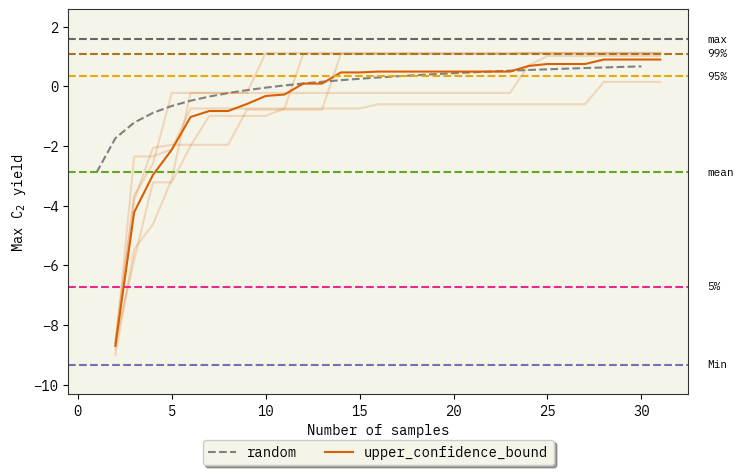

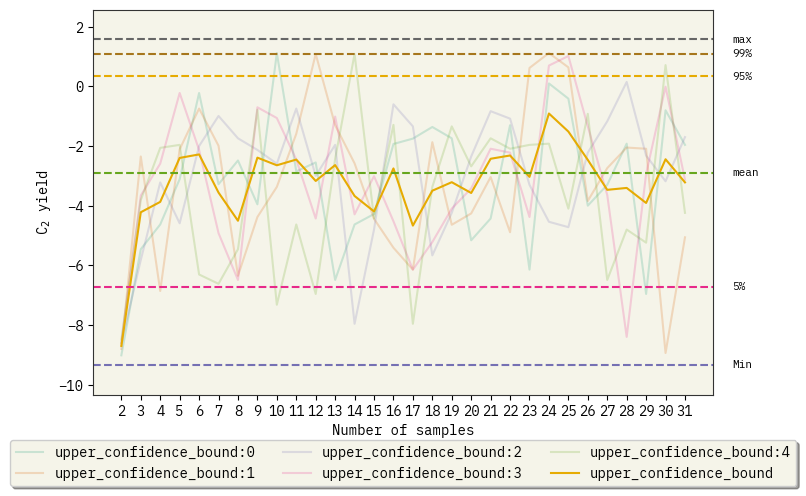

In [49]:
# Quick test
path = "./out/sol_gpt-3.5-turbo_1_1.pkl"
title = "" #"gpt-3.5-turbo-0125" #f"{path[6:-4]} 
d = cloudpickle.load(open(path, "rb"))
# d = bayesOpts
data=raw_data[y_name]
lim=(data.min()-1, data.max()+1)

# name = "LogS"
name = "C$_2$ yield"
# name = "CO STY"

def plot_config():
    plt.title(title)
    plt.axhline(y=data.max(), color="C15", linestyle="--")
    plt.text(plt.xlim()[1]+1, data.max(), "max", va="center", ha="left", backgroundcolor="w", fontsize=8)
    plt.axhline(y=data.quantile(0.99), color="C14", linestyle="--")
    plt.text(plt.xlim()[1]+1, data.quantile(0.99), "99%", va="center", ha="left", backgroundcolor="w", fontsize=8)
    plt.axhline(y=data.quantile(0.95), color="C13", linestyle="--")
    plt.text(plt.xlim()[1]+1, data.quantile(0.95), "95%", va="center", ha="left", backgroundcolor="w", fontsize=8)
    plt.axhline(y=data.mean(), color="C12", linestyle="--")
    plt.text(plt.xlim()[1]+1, data.mean(), "mean", va="center", ha="left", backgroundcolor="w", fontsize=8)
    plt.axhline(y=data.quantile(0.05), color="C11", linestyle="--")
    plt.text(plt.xlim()[1]+1, data.quantile(0.05), "5%", va="center", ha="left", backgroundcolor="w", fontsize=8)
    plt.axhline(y=data.min(), color="C10", linestyle="--")
    plt.text(plt.xlim()[1]+1, data.min(), "Min", va="center", ha="left", backgroundcolor="w", fontsize=8)
    plt.ylim(lim)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.1),
          fancybox=True, shadow=True, ncol=3)

#Debugging plots
# Plot best value on the entire run
plt.figure(figsize=(8,5))
plt.xlabel("Number of samples")
# plt.ylabel("Max C$_2$ yield")
plt.ylabel(f"Max {name}")

for i, acq in enumerate(d.keys()):
    if acq in ["log_expected_improvement", "random", "greedy", "random"]:
        continue
    if acq == "random_mean":
        plt.plot(d[acq][0,:,0].astype(int), d[acq][:, :, 1].astype(float).mean(axis=0), 
                 label=f"random", color="gray", linestyle="dashed")
    else:
        for j in range(M):
            try:
                plt.plot(d[acq][j,:,1].astype(int), d[acq][j,:, 2].astype(float), alpha=0.2, color=f"C{i}")
            except:
                continue
        plt.plot(d[acq][0,:,1].astype(int), d[acq][:, :, 2].astype(float).mean(axis=0), label=acq, color=f"C{i}")
plot_config()
# plt.ylim(-6, 2)
plt.show()

# Plot current values on each iteration
plt.figure(figsize=(8,5))
plt.xlabel("Number of samples")
plt.ylabel(f"{name}")
for acq in d.keys():
    if acq in ["random_mean", "log_expected_improvement", "random", "greedy", "random"]:
        continue
    else:
        for i in range(M):
            plt.plot(d[acq][i,:,1], d[acq][i, :, 3].astype(float), label=f"{acq}:{i}", alpha=0.2)
        plt.plot(d[acq][0,:,1], d[acq][:, :, 3].astype(float).mean(axis=0), label=f"{acq}")
plot_config()
plt.show()


In [ ]:
for key, value in d.items():
    print(key, value.shape)


## BayesOpt Plot

In [ ]:
def plot_BO(ax, data_file, title, data, axis_name, lim=None, label=False, M=1):
    d = cloudpickle.load(open(data_file, "rb"))

    for i in range(M):
        if "expected_improvement" in d.keys():
          ax.plot(
            [int(s) for s in d['expected_improvement'][i, :, 1]],
            [float(y) for y in d['expected_improvement'][i, :, 2]], 
            color="C1", alpha=0.2
          )
        if "greedy" in d.keys():
           ax.plot(
            [int(s) for s in d['greedy'][i, :, 1]],
            [float(y) for y in d['greedy'][i, :, 2]], 
            color="C2", alpha=0.2
          )
        if "upper_confidence_bound" in d.keys():
          ax.plot(
            [int(s) for s in d['upper_confidence_bound'][i, :, 1]],
            [float(y) for y in d['upper_confidence_bound'][i, :, 2]], 
            color="C3", alpha=0.2
          )
        if "probability_of_improvement" in d.keys():
          ax.plot(
            [int(s) for s in d['probability_of_improvement'][i, :, 1]],
            [float(y) for y in d['probability_of_improvement'][i, :, 2]], 
            color="C4", alpha=0.2
          )
        if "random" in d.keys():
          ax.plot(
            [int(s) for s in d['random'][i, :, 1]],
            [float(y) for y in d['random'][i, :, 2]], 
            color="C8", alpha=0.2
          )
    if "expected_improvement" in d.keys():
      label = "EI" if label else None
      ax.plot(
            d['expected_improvement'][:, :, 1].astype('int').mean(axis=0),
            d['expected_improvement'][:, :, 2].astype('float').mean(axis=0), 
            color="C1", label=label
          )
    if "greedy" in d.keys():
      label = "Greedy" if label else None
      ax.plot(
            d['greedy'][:, :, 1].astype('int').mean(axis=0),
            d['greedy'][:, :, 2].astype('float').mean(axis=0), 
            color="C2", label=label
          )
    if "upper_confidence_bound" in d.keys():
      label = "UCB" if label else None
      ax.plot(
            d['upper_confidence_bound'][:, :, 1].astype('int').mean(axis=0),
            d['upper_confidence_bound'][:, :, 2].astype('float').mean(axis=0), 
            color="C3", label=label
          )
    if "probability_of_improvement" in d.keys():
      label = "POI" if label else None
      ax.plot(
            d['probability_of_improvement'][:, :, 1].astype('int').mean(axis=0),
            d['probability_of_improvement'][:, :, 2].astype('float').mean(axis=0), 
            color="C4", label=label
          )
    if "random" in d.keys():
      label = "random" if label else None
      ax.plot(
            d['random'][:,:, 1].astype('int').mean(axis=0),
            d['random'][:,:, 2].astype('float').mean(axis=0), 
            color="C8", label=label
          )
    if "random_mean" in d.keys():
      label = "Random" if label else None
      ax.plot(
            d['random_mean'][:, :, 0].astype('int').mean(axis=0),
            d['random_mean'][:, :, 1].astype('float').mean(axis=0), 
            color="gray", label=label, linestyle="dashed"
      )
    ax.axhline(y=data.max(), color="C15", linestyle="--")
    ax.text(ax.get_xlim()[1]+1, data.max(), "max", va="center", ha="left", backgroundcolor="w", fontsize=8)
    ax.axhline(y=data.quantile(0.99), color="C14", linestyle="--")
    ax.text(ax.get_xlim()[1]+1, data.quantile(0.99), "99%", va="center", ha="left", backgroundcolor="w", fontsize=8)
    ax.axhline(y=data.quantile(0.95), color="C13", linestyle="--")
    ax.text(ax.get_xlim()[1]+1, data.quantile(0.95), "95%", va="center", ha="left", backgroundcolor="w", fontsize=8)
    ax.axhline(y=data.mean(), color="C12", linestyle="--")
    ax.text(ax.get_xlim()[1]+1, data.mean(), "mean", va="center", ha="left", backgroundcolor="w", fontsize=8)
    if not data_file.startswith("./out/sol"):
      ax.axhline(y=data.quantile(0.05), color="C11", linestyle="--")
      ax.text(ax.get_xlim()[1]+1, data.quantile(0.05)+0.3, "5%", va="center", ha="left", backgroundcolor="w", fontsize=8)
      ax.axhline(y=data.min(), color="C10", linestyle="--")
      ax.text(ax.get_xlim()[1]+1, data.min()-0.3, "min", va="center", ha="left", backgroundcolor="w", fontsize=8)
    ax.set_title(title)

    ax.set_xlabel("Number of samples")
    ax.set_ylabel(f"Measured {axis_name}")
    # ax.set_xticks([i for i in range(0,N+1,5)], [str(x * 1) for x in [i for i in range(0,N+1,5)]])
    if lim:
      ax.set_ylim(lim)
    ax.set_title(title)

### Paper figures

In [ ]:
raw_data, starts, indexes, x_name, y_name = get_dataset("ocm", M=0)

In [ ]:
path

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4,4), constrained_layout=True)
# for ax in axs.flat:
#     ax.set_aspect(0.6)

lim=(raw_data[y_name].min()-1, raw_data[y_name].max()+1)
# plot_BO(axs[0], "./out/ocm_curie_12744_1_1_16nr.pkl","GPT3", 
#          raw_data[y_name], "C$_2$ yield", lim, label=True, M=5)

# plot_BO(axs[0], "./out/biasfree_ocm_gpt-turbo_300_1_1_lambda_mult0.1_corrected.pkl","Bias Free: lambda .1_corrected",
#          raw_data[y_name], "C$_2$ yield", lim, label=True, M=5)

# plot_BO(axs[1], "./out/biasfree_ocm_gpt-turbo_300_1_1_lambda_mult0.5_corrected.pkl","Bias Free: lambda .5_corrected",
#          raw_data[y_name], "C$_2$ yield", lim, label=False, M=5)

# plot_BO(axs[2], "/Users/shane/repos/BO-LIFT/paper/out/biasfree_ocm_gpt-turbo_300_1_1_lambda_mult0.9_corrected.pkl","Bias Free: lambda .9_corrected",
#          raw_data[y_name], "C$_2$ yield", lim, label=False, M=5)


# plot_BO(axs, "./out/biasfree_ocm_gpt-turbo_300_1_1_lambda_mult0.1_corrected_tableprompt_transfer_data_10.pkl","GPT 4 Bias Free Table Format t_train=10: lambda .1",
#          raw_data[y_name], "C$_2$ yield", lim, label=True, M=5)


plot_BO(axs, path,"Bias Free Table Format_large: 100_t_train_non_random lambda .1 ",
         raw_data[y_name], "C$_2$ yield", lim, label=True, M=5)

# plot_BO(axs[1], './out/biasfree_ocm_gpt-turbo_300_1_1_lambda_mult0.1_corrected_tableprompt_transfer_data_100.pkl'," GPT4 Table Format: lambda .1",
#          raw_data[y_name], "C$_2$ yield", lim, label=False, M=5)

# plot_BO(axs[4], "/Users/shane/repos/BO-LIFT/paper/out/biasfree_ocm_gpt-turbo_300_1_1_lambda_mult1.pkl","Bias Free: lambda 1",
#          raw_data[y_name], "C$_2$ yield", lim, label=False, M=5)

# plot_BO(axs[3], "/Users/shane/repos/BO-LIFT/paper/out/biasfree_ocm_gpt-turbo_300_1_1_lambda_mult1_corrected_1.pkl","Bias Free: lambda 1_corrected",
#          raw_data[y_name], "C$_2$ yield", lim, label=False, M=5)


# path = f"./out/{dataset}_{model}_300_{initial_train}_{ask_K}_lambda_mult{lambda_multi}.pkl"

# plot_BO(axs[1], "./out/ocm_GPT-4_12744_0_s.pkl", "GPT4",
#          raw_data[y_name], "C$_2$ yield", lim, label=False, M=5)
# d
# plot_BO(axs[2], "./out/biasfree_ocm_gpt-turbo_300_1_1_lambda_mult0.1_corrected_tablepromptgpt4_1.5*normal.pkl", "GPT4 Table Format: lambda .1 - 1.5*",
#          raw_data[y_name], "C$_2$ yield", lim, label=False, M=5)

# plot_BO(axs[3], "/Users/shane/repos/BO-LIFT/paper/out/biasfree_ocm_gpt-turbo_300_1_1_lambda_mult0.1_corrected_tablepromptgpt4_1.5*normal_meanstart.pkl", "GPT4 Table Format (mean): lambda .1 - 1.5*",
#          raw_data[y_name], "C$_2$ yield", lim, label=False, M=5)

fig.suptitle("Bayesian Optimization on OCM dataset")
fig.legend(loc='upper center', bbox_to_anchor=(0.5,0),
          fancybox=True, shadow=True, ncol=6)
# plt.savefig(f"figs/BO_C2", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4), constrained_layout=True)
axs = axs.flatten()
# for ax in axs.flat:
#     ax.set_aspect(0.6)

lim=(raw_data[y_name].min()-1, raw_data[y_name].max()+1)

plot_BO(axs[0], "./out/ocm_gpt35turbo_12744_1_1_test0.pkl","GPT3.5-turbo: 1.2",
         raw_data[y_name], "C$_2$ yield", lim, label=True, M=5)

plot_BO(axs[1], "./out/ocm_gpt35instruct_12744_5_1_test8.pkl ", "GPT3.5-turbo: 1.2",
         raw_data[y_name], "C$_2$ yield", lim, label=False, M=5)

fig.suptitle("Bayesian Optimization on OCM dataset")
fig.legend(loc='upper center', bbox_to_anchor=(0.5,0),
          fancybox=True, shadow=True, ncol=6)
plt.savefig(f"figs/BO_C2", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
d_curie = cloudpickle.load(open("./out/ocm_curie_12744_1_1_16nr.pkl", "rb"))
d_davinci = cloudpickle.load(open("./out/C2_davinci2_12744_1_16nr.pkl", "rb"))
d_gpt4 = cloudpickle.load(open("./out/ocm_GPT-4_12744_0_s.pkl", "rb"))
d_gpr = cloudpickle.load(open("./out/C2_gpr_12744_1_16nr.pkl", "rb"))

print(d_curie['expected_improvement'][:, -1, 2].astype(float))
best_curie = d_curie['expected_improvement'][:, :, 2].astype(float).mean(axis=0)[-1]
print(f"Curie is top{np.sum(raw_data[y_name] > best_curie)}: {best_curie}")

print(d_davinci['expected_improvement'][:, -1, 2].astype(float))
best_davinci = d_davinci['expected_improvement'][:, :, 2].astype(float).mean(axis=0)[-1]
print(f"DaVinci is top{np.sum(raw_data[y_name] > best_davinci)}: {best_davinci}")

print(d_gpt4['expected_improvement'][:, -1, 2].astype(float))
best_gpt4 = d_gpt4['expected_improvement'][:, :, 2].astype(float).mean(axis=0)[-1]
print(f"Gpt4 is top{np.sum(raw_data[y_name] > best_gpt4)}: {best_gpt4}")

print(d_gpr['expected_improvement'][:, -1, 2].astype(float))
best_gpr = d_gpr['expected_improvement'][:, :, 2].astype(float).mean(axis=0)[-1]
print(f"GPR is top{np.sum(raw_data[y_name] > best_gpr)}: {best_gpr}")

sns.histplot(raw_data[y_name])
# print(np.sum(raw_data[y_name] > best))
plt.xlabel("measured C$_2$ yield")
plt.axvline(best_curie, color='C4', linestyle='--', label="Curie")
plt.axvline(best_davinci, color='C1', linestyle='--', label="Davinci")
plt.axvline(best_gpt4, color='C2', linestyle='--', label="GPT4")
plt.axvline(best_gpr, color='C3', linestyle='--', label="GPR")
plt.legend()
plt.savefig(f"figs/hist_C2", dpi=300, bbox_inches='tight')
plt.show()

print(raw_data[raw_data[y_name] > best_davinci])



In [ ]:
raw_data, starts, indexes, x_name, y_name = get_dataset("sol", M=0)

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,4), constrained_layout=True)
# for ax in axs.flat:
#     ax.set_aspect(1.8)

lim=(raw_data[y_name].mean()-1, raw_data[y_name].max()+1)

plot_BO(axs[0], "./out/sol_davinci_100.pkl", "GPT3.5",
         raw_data[y_name], "LogS solubility", lim, label=False)
plot_BO(axs[1], "./out/sol_gpt4_100.pkl", "GPT4",
         raw_data[y_name], "LogS solubility", lim, label=False)
plot_BO(axs[2], "./out/sol_GPR_100.pkl", "GPR",
         raw_data[y_name], "LogS solubility", lim, label=True)

fig.legend(loc='upper center', bbox_to_anchor=(0.5,0),
          fancybox=True, shadow=True, ncol=6)
plt.savefig(f"figs/BO_sol", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
d_davinci = cloudpickle.load(open("./out/sol_davinci_100.pkl", "rb"))
d_gpt4 = cloudpickle.load(open("./out/sol_gpt4_100.pkl", "rb"))
d_gpr = cloudpickle.load(open("./out/sol_GPR_100.pkl", "rb"))

print(d_davinci['expected_improvement'][:, -1, 2].astype(float))
best_davinci = d_davinci['expected_improvement'][:, :, 2].astype(float).mean(axis=0)[-1]
print(f"DaVinci is top{np.sum(raw_data[y_name] > best_davinci)}: {best_davinci}")

print(d_gpt4['expected_improvement'][:, -1, 2].astype(float))
best_gpt4 = d_gpt4['expected_improvement'][:, :, 2].astype(float).mean(axis=0)[-1]
print(f"Gpt4 is top{np.sum(raw_data[y_name] > best_gpt4)}: {best_gpt4}")

print(d_gpr['expected_improvement'][:, -1, 2].astype(float))
best_gpr = d_gpr['expected_improvement'][:, :, 2].astype(float).mean(axis=0)[-1]
print(f"GPR is top{np.sum(raw_data[y_name] > best_gpr)}: {best_gpr}")

sns.histplot(raw_data[y_name])
plt.axvline(best_davinci, color='C1', linestyle='--', label="Davinci")
plt.axvline(best_gpt4, color='C2', linestyle='--', label="GPT4")
plt.axvline(best_gpr, color='C3', linestyle='--', label="GPR")
plt.legend()
plt.savefig(f"figs/hist_sol", dpi=300, bbox_inches='tight')
plt.show()

print(raw_data[raw_data[y_name] > best_davinci-0.08])



### C2

In [ ]:
# np.random.seed(88)

# data_path = "./dataset/data/12744_ocm_dataset.csv"
# raw_data = pd.read_csv(data_path, sep=";")
# # raw_data = raw_data.sample(frac=1).reset_index(drop=True)
# # raw_data['completion'] = - raw_data['completion']

# x_name = "prompt"
# y_name = "completion"

In [ ]:
raw_data, starts, indexes, x_name, y_name = get_dataset("ocm", M=5)

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,4), constrained_layout=True)
# for ax in axs.flat:
#     ax.set_aspect(0.6)

lim=(0,8)
raw_data = pd.read_csv("dataset/data/1180_ocm_dataset.csv", sep=";")
plot_BO(axs[0], "./out/C2_davinci_1180_1_tree.pkl","20", 
         raw_data[y_name], "C$_2$ yield", lim, label=True, data_file_random="./out/C2 - random - 1180.pkl")

lim=(0,10)
raw_data = pd.read_csv("dataset/data/2950_ocm_dataset.csv", sep=";")
plot_BO(axs[1], "./out/C2_davinci_2950_1_tree.pkl","50",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 2950.pkl")

lim=(0,25)
raw_data = pd.read_csv("dataset/data/5900_ocm_dataset.csv", sep=";")
plot_BO(axs[2], "./out/C2_davinci_5900_1_tree.pkl", "100",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 5900.pkl")

lim=(0,25)
raw_data = pd.read_csv("dataset/data/12744_ocm_dataset.csv", sep=";")
plot_BO(axs[3], "./out/C2_davinci_12744_1_tree_2.pkl", "216",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 12744.pkl")

fig.suptitle("TreePool with davinci")
fig.legend(loc='upper center', bbox_to_anchor=(0.5,0),
          fancybox=True, shadow=True, ncol=6)
plt.savefig(f"figs/BO_C2", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
pools = [
    './out/C2_davinci_1180_1_tree.pkl',
    './out/C2_davinci_2950_1_tree.pkl',
    './out/C2_davinci_5900_1_tree.pkl',
    './out/C2_davinci_12744_1_tree.pkl',
]
for p in pools:
    print(p)
    d = cloudpickle.load(open(p, "rb"))
    for run in d['upper_confidence_bound'][:, :, 0]:
        print([r[14:r.find(",")] for r in run])
    
    print()

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,4), constrained_layout=True)
# for ax in axs.flat:
#     ax.set_aspect(0.6)

lim=(0,8)
raw_data = pd.read_csv("dataset/data/1180_ocm_dataset.csv", sep=";")
plot_BO(axs[0], "./out/C2_davinci_1180_1_16hh.pkl","20", 
         raw_data[y_name], "C$_2$ yield", lim, label=True, data_file_random="./out/C2 - random - 1180.pkl")

lim=(0,10)
raw_data = pd.read_csv("dataset/data/2950_ocm_dataset.csv", sep=";")
plot_BO(axs[1], "./out/C2_davinci_2950_1_16hh.pkl","50",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 2950.pkl")

lim=(0,25)
raw_data = pd.read_csv("dataset/data/5900_ocm_dataset.csv", sep=";")
plot_BO(axs[2], "./out/C2_davinci_5900_1_16hh.pkl", "100",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 5900.pkl")

lim=(0,25)
raw_data = pd.read_csv("dataset/data/12744_ocm_dataset.csv", sep=";")
plot_BO(axs[3], "./out/C2_davinci_12744_1_16hh.pkl", "216",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 12744.pkl")
         

fig.suptitle("Subpool of 16 with half random samples with davinci")
fig.legend(loc='upper center', bbox_to_anchor=(0.5,0),
          fancybox=True, shadow=True, ncol=6)
plt.savefig(f"figs/BO_C2", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
pools = [
    './out/C2_davinci_1180_1_16hh.pkl',
    './out/C2_davinci_2950_1_16hh.pkl',
    './out/C2_davinci_5900_1_16hh.pkl',
    './out/C2_davinci_12744_1_16hh.pkl',
]
for p in pools:
    print(p)
    d = cloudpickle.load(open(p, "rb"))
    for run in d['upper_confidence_bound'][:, :, 0]:
        print([r[14:r.find(",")] for r in run])
    
    print()

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,4), constrained_layout=True)
# for ax in axs.flat:
#     ax.set_aspect(0.6)

lim=(0,25)
raw_data = pd.read_csv("dataset/data/12744_ocm_dataset.csv", sep=";")
plot_BO(axs[0], "./out/C2_davinci_fulldataset_new_subpool_16_allrandom_1init.pkl","all_random",
         raw_data[y_name], "C$_2$ yield", lim, label=True, data_file_random="./out/C2 - random - 12744.pkl")

plot_BO(axs[1], "./out/C2_davinci_12744_1_16hh.pkl","half_random",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 12744.pkl")

plot_BO(axs[2], "./out/C2_davinci_fulldataset_subpool_16_no_random_1_init.pkl", "no_random",
# plot_BO(axs[2], "./out/C2_davinci_fulldataset_subpool_16_no_random_newest_seed0_2_init.pkl", "no_random",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 12744.pkl")

plot_BO(axs[3], "./out/C2_davinci_12744_1_tree_2.pkl", "TreePool",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 12744.pkl")
         

fig.suptitle("216 samples with each subpool")
fig.legend(loc='upper center', bbox_to_anchor=(0.5,0),
          fancybox=True, shadow=True, ncol=6)
plt.savefig(f"figs/BO_C2", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
pools = [
    # './out/C2_davinci_fulldataset_new_subpool_16_allrandom_1init.pkl',
    # './out/C2_davinci_12744_1_16hh.pkl',
    # './out/C2_davinci_fulldataset_subpool_16_no_random_1_init.pkl',
    './out/C2_davinci_fulldataset_subpool_16_no_random_newest_seed0_2_init.pkl',
    # './out/C2_davinci_12744_1_tree.pkl',
]
for p in pools:
    print(p)
    d = cloudpickle.load(open(p, "rb"))
    for k in d.keys():
        for run in d[k][:, :, 0]:
            print(k, [r[14:r.find(",")] for r in run])
    
    print()

In [ ]:
d_davinci = cloudpickle.load(open("paper/out/C2_davinci_100.pkl", "rb"))
print(d_davinci['expected_improvement'][:, -1, 1].astype(float))
best_davinci = d_davinci['expected_improvement'][:, :, 1].astype(float).mean(axis=0)[-1]
print(f"DaVinci is top{np.sum(raw_data[y_name] > best_davinci)}: {best_davinci}")

d_gpt4 = cloudpickle.load(open("paper/out/C2_GPT4_100.pkl", "rb"))
print(d_gpt4['upper_confidence_bound'][:, -1, 1].astype(float))
best_gpt4 = d_gpt4['upper_confidence_bound'][:, :, 1].astype(float).mean(axis=0)[-1]
print(f"Gpt4 is top{np.sum(raw_data[y_name] > best_gpt4)}: {best_gpt4}")

d_gpr = cloudpickle.load(open("paper/out/C2_GPR_100.pkl", "rb"))
print(d_gpr['expected_improvement'][:, -1, 1].astype(float))
best_gpr = d_gpr['upper_confidence_bound'][:, :, 1].astype(float).mean(axis=0)[-1]
print(f"GPR is top{np.sum(raw_data[y_name] > best_gpr)}: {best_gpr}")

sns.histplot(raw_data[y_name])
# print(np.sum(raw_data[y_name] > best))
plt.xlabel("measured C$_2$ yield")
plt.axvline(best_davinci, color='C1', linestyle='--', label="Davinci")
plt.axvline(best_gpt4, color='C2', linestyle='--', label="GPT4")
plt.axvline(best_gpr, color='C3', linestyle='--', label="GPR")
plt.legend()
plt.savefig(f"figs/hist_C2", dpi=300, bbox_inches='tight')
plt.show()

print(raw_data[raw_data[y_name] > best_davinci])



### iupac-sol

In [ ]:
np.random.seed(0)
data_path = "paper/data/esol_iupac.csv"
raw_data = pd.read_csv(data_path)
raw_data = raw_data.dropna()
raw_data = raw_data[["IUPAC", "measured log(solubility:mol/L)"]]
raw_data = raw_data.sample(frac=1).reset_index(drop=True)

# raw_data['measured log(solubility:mol/L)'] = -raw_data['measured log(solubility:mol/L)']
x_name = "IUPAC"
y_name = "measured log(solubility:mol/L)"

In [ ]:
raw_data, starts, indexes, x_name, y_name = get_dataset("sol", M=5)

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4), constrained_layout=True)
for ax in axs.flat:
    ax.set_aspect(1.8)

lim=(-5.5,2)

plot_BO(axs[0], "paper/out/sol_davinci_100.pkl", "Topk - davinci",
         raw_data[y_name], "LogS solubility", lim, label=False, data_file_random="paper/out/sol - random.pkl")
plot_BO(axs[1], "paper/out/sol_gpt4_100.pkl", "Topk - GPT-4",
         raw_data[y_name], "LogS solubility", lim, label=False, data_file_random="paper/out/sol - random.pkl")
plot_BO(axs[2], "paper/out/sol_GPR_100.pkl", "GPR",
         raw_data[y_name], "LogS solubility", lim, label=True, data_file_random="paper/out/sol - random.pkl")

fig.legend(loc='upper center', bbox_to_anchor=(0.5,0),
          fancybox=True, shadow=True, ncol=6)
plt.savefig(f"figs/BO_sol", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
d_davinci = cloudpickle.load(open("paper/out/sol_davinci_100.pkl", "rb"))
d_gpt4 = cloudpickle.load(open("paper/out/sol_gpt4_100.pkl", "rb"))
d_gpr = cloudpickle.load(open("paper/out/sol_GPR_100.pkl", "rb"))

print(d_davinci['expected_improvement'][:, -1, 1].astype(float))
best_davinci = d_davinci['expected_improvement'][:, :, 1].astype(float).mean(axis=0)[-1]
print(f"DaVinci is top{np.sum(raw_data[y_name] > best_davinci)}: {best_davinci}")

print(d_gpt4['expected_improvement'][:, -1, 1].astype(float))
best_gpt4 = d_gpt4['expected_improvement'][:, :, 1].astype(float).mean(axis=0)[-1]
print(f"Gpt4 is top{np.sum(raw_data[y_name] > best_gpt4)}: {best_gpt4}")

print(d_gpr['expected_improvement'][:, -1, 1].astype(float))
best_gpr = d_gpr['expected_improvement'][:, :, 1].astype(float).mean(axis=0)[-1]
print(f"GPR is top{np.sum(raw_data[y_name] > best_gpr)}: {best_gpr}")

sns.histplot(raw_data[y_name])
plt.axvline(best_davinci, color='C1', linestyle='--', label="Davinci")
plt.axvline(best_gpt4, color='C2', linestyle='--', label="GPT4")
plt.axvline(best_gpr, color='C3', linestyle='--', label="GPR")
plt.legend()
plt.savefig(f"figs/hist_sol", dpi=300, bbox_inches='tight')
plt.show()

print(raw_data[raw_data[y_name] > best_davinci-0.08])

